# IBM AI Workflow Capstone Project
Revenue Forecast for AAVAIL Streaming Service

## Part 1 - Data Investigation

A core business objective at AAVAIL is to expand its streaming service globally and generate more revenue in the process. A crucial step in  achieving such objective is the ability to reliably make country-wise revenue projections. The goal of this project is to develop a model capable of making monthly revenue projections.

#### Hypothesis
Can we generate more revenue by increasing views count?<br>

#### Data Ingestion

In [14]:
from model_1 import load_data
import os, glob

train_dir = os.path.join('ai-workflow-capstone','cs-train')
production_dir = os.path.join('ai-workflow-capstone','cs-production') 
filepath = os.path.join('data','processed_data.csv')

df = load_data('invoices**.JSON').fit(train_dir).transform(train_dir)
df

,country,customer_id,invoice,price,stream_id,times_viewed,year,month,day
0,United Kingdom,13085.0,489434,6.95,85048,12,2017,11,28
1,United Kingdom,NaN,489597,8.65,22130,1,2017,11,28
2,United Kingdom,NaN,489597,1.70,22132,6,2017,11,28
3,United Kingdom,NaN,489597,1.70,22133,4,2017,11,28
4,United Kingdom,NaN,489597,0.87,22134,1,2017,11,28
...,...,...,...,...,...,...,...,...,...
815006,United Kingdom,15628.0,562163,0.85,21544,12,2019,7,31
815007,United Kingdom,15628.0,562163,1.95,47591D,8,2019,7,31
815008,United Kingdom,15628.0,562163,0.83,23167,12,2019,7,31
815009,United Kingdom,15628.0,562163,4.95,22138,3,2019,7,31


#### Exploratory Data Analysis

In [15]:
from EDA import total_by_country, most_viewed, to_date, global_monthly_revenue
from EDA import global_weekly_revenue, global_daily_revenue

df1 = to_date(df)

Top earning countries
-------------------------
                     revenue  times_viewed
country                                   
United Kingdom  3.521514e+06     3725703.0
EIRE            1.070692e+05      111636.0
Germany         4.927182e+04      112618.0
France          4.056514e+04       83124.0
Norway          3.849475e+04        7881.0

Least earning countries
-------------------------
                revenue  times_viewed
country                              
West Indies      122.77         313.0
Nigeria          109.28          61.0
Bermuda           84.70         361.0
Czech Republic    31.83         166.0
Saudi Arabia      24.11          81.0

UK vs other countries
-------------------------
                      revenue  times_viewed
United Kingdom   3.521514e+06     3725703.0
other countries  3.926839e+05      537706.0


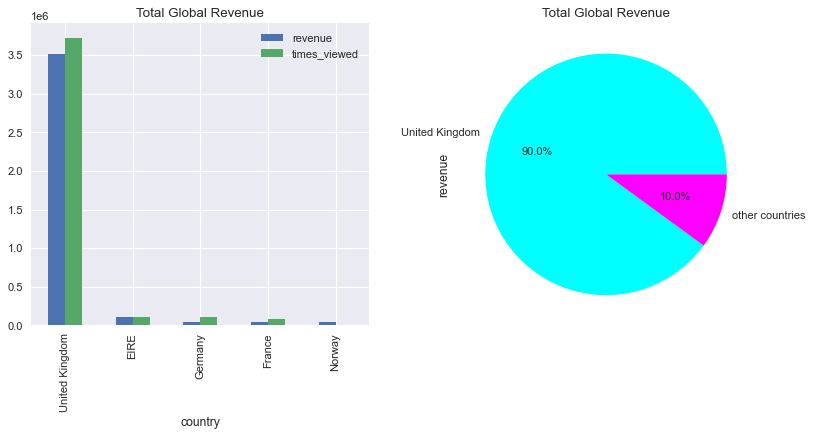

In [16]:
total_by_country(df1)

               revenue  times_viewed
date                                
2017-11-30   41152.750       44972.0
2017-12-31  157155.010      165047.0
2018-01-31  183680.394      176494.0
2018-02-28  116345.374      157529.0
2018-03-31  257428.441      201318.0


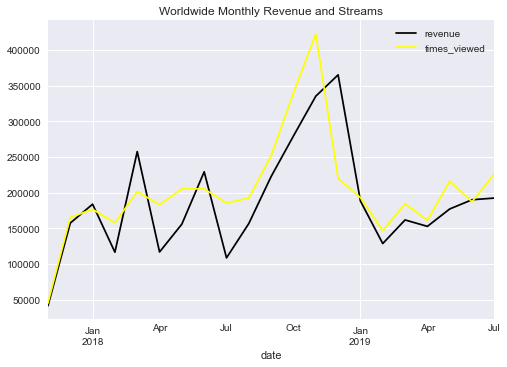

In [17]:
df_monthly = global_monthly_revenue(df1)

             revenue  times_viewed
date                              
2017-12-03  58716.23       69353.0
2017-12-10  54730.84       64293.0
2017-12-17  66395.70       64915.0
2017-12-24  18464.99       11458.0
2017-12-31      0.00           0.0


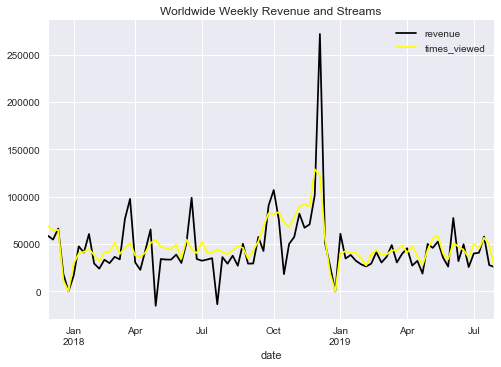

In [18]:
global_weekly_revenue(df1)

             revenue  times_viewed
date                              
2017-11-28  14450.54       15047.0
2017-11-29  13411.96       14159.0
2017-11-30  13290.25       15766.0
2017-12-01   9687.28       12524.0
2017-12-02   1443.26        3313.0


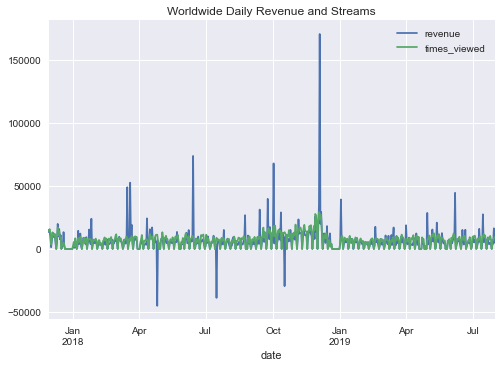

In [19]:
global_daily_revenue(df1)

#### Hypothesis Testing

* __Null__: Views count and revenue (independent samples) are similar
* __Alternative__: views count and revenue are unrelated
<br>Assuming $\alpha = 0.05$

#### t-test: independent

In [6]:
from scipy.stats import ttest_ind
revenue = df_monthly.revenue.tolist()
views = df_monthly.times_viewed.tolist()
stat,p = ttest_ind(revenue,views,equal_var=True)
print('p-value: {}'.format(round(p,5)))

p-value: 0.47333


Given that $p>\alpha$, we accept the __null__ hypothesis that _revenue_ and _views_ have the same distribution. Thus, we can generate more revenue by increasing the views.

### Feature Engineering
Our model in this project will take _country_ and _date_ inputs and project the revenue in the following month (30-day period). The feature engineering steps to prepare the training data are as follows:
1. Drop irrelevant features
2. Remove outliers (such as negative price)
3. Convert data to daily time series
4. Impute days without entries
5. Extract the querried date and country

In [20]:
from model_1 import preprocess_data, load_extract

preprocess_data(filepath,remove_existing=True).fit().transform(df)  #preprocess data and save to a directory

test_query = {'country':'Belgium','date':'2019-06-15'}  # sample query
test_df = load_extract().fit().transform(test_query)    # fetch query
test_df.head()

,price,times_viewed
date,,
2017-11-28,130.0,1.0
2017-11-29,0.0,0.0
2017-11-30,0.0,0.0
2017-12-01,0.0,0.0
2017-12-02,0.0,0.0


In [21]:
# try for all countries
test_query2 = {'country':'all','date':'2019-06-15'}
test_df2 = load_extract().fit().transform(test_query2) 
test_df2.head()

,price,times_viewed
date,,
2017-11-28,14450.54,15047.0
2017-11-29,13411.96,14159.0
2017-11-30,13290.25,15766.0
2017-12-01,9687.28,12524.0
2017-12-02,1443.26,3313.0


In [22]:
# When no date is specified... (use month end)
test_query3 = {'country':'Australia'}
test_df3 = load_extract().fit().transform(test_query3) 
test_df3.head()

,price,times_viewed
date,,
2017-11-28,40.4,97.0
2017-11-29,0.0,0.0
2017-11-30,0.0,0.0
2017-12-01,0.0,0.0
2017-12-02,0.0,0.0


## Part 2 - Model Iteration
Models to consider:
1. A simple __baseline__ model that makes predictions by *averaging* past observations
2. A __supervised learning__ *XGBoost regresion* model, and
3. A classic __time series__ *ARIMA* model

In [11]:
from sklearn.metrics import mean_absolute_error
from model_1 import AVG_forecast, ARIMA_forecast, XGR_forecast, model_iter

models = [AVG_forecast(n_steps=5),
          XGR_forecast(n_steps=5,max_depth=1,reg_alpha=1.0,reg_lambda=5.0,gamma=5.1),
          ARIMA_forecast(n_steps=5,dynamic=True)]

In [12]:
# let's include the dataset in the production directory

#df_prod = load_data('invoices**.JSON').fit(train_dir).transform(production_dir)
#preprocess_data(filepath,remove_existing=False).fit().transform(df_prod)
df_bel = load_extract().fit().transform(test_query3) 

C:\Users\miket\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


           mean_absolute_error
Averaging           351.268275
XGR                 104.800840
ARIMA                89.740364


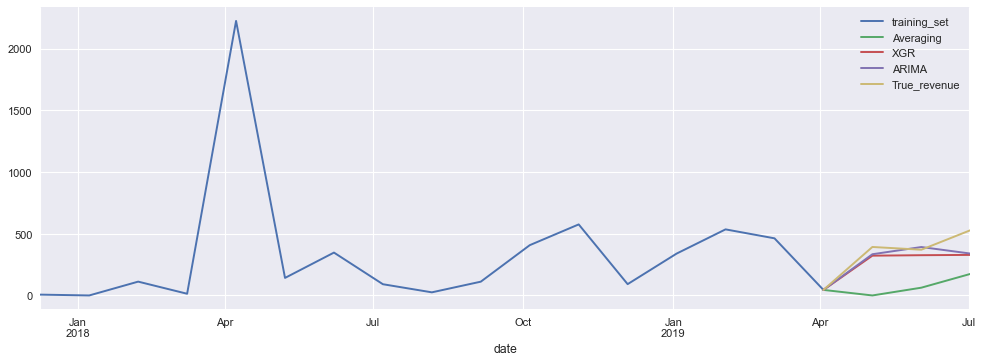

In [23]:
#Evaluate all three models with a country dataset

model_iter(models,test_df3)

           mean_absolute_error
Averaging         52607.534725
XGR              130262.265910
ARIMA              6145.950077


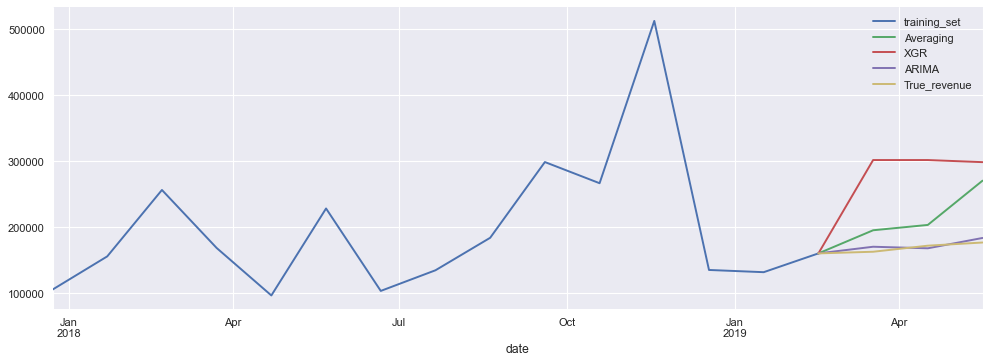

In [24]:
#Using a dataset for all countries combined
model_iter(models,test_df2)

In addition to having the lowest mean absolute error, the ARIMA model projected a revenue trend that is somewhat similar to the true observed data in this instance. However, there are instances where the ARIMA model fails to converge for a given set of parameters due to the highly varying nature of the input dataset. In practice, there is no single model that works across all countries for all target dates, but for this project, the ARIMA model is chosen.

## Part 3: Model Production

### Unit tests

#### * Logger Test
The following will be tested:
* predict log is automatically created
* train log is automatically created
* content can be retrieved from predict log file
* content can be retrieved from train log file

In [27]:
!python LoggerTests.py

....
----------------------------------------------------------------------
Ran 4 tests in 0.018s

OK


#### * API Test
The following will be tested:
* model can be trained
* trained model is saved and can make a prediction
* logs are automatically created and queries are logged

In [29]:
# Launch the app in terminal


In [30]:
!python ApiTests.py

{'forecast': 543}

...
----------------------------------------------------------------------
Ran 3 tests in 5.184s

OK


### Test API query   

In [31]:
import requests

query = {'country':'Belgium','date':'2019-06-20'}
r = requests.post('http://127.0.0.1:{}/predict'.format(8882), json=query)
r.content

b'{\n  "forecast": 550\n}\n'